In [1]:
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Polygon, Point
from shapely import plotting
import math

In [ ]:
def calculate_support_polygon(angles, leg_radius=1):
    """
    Calculate the support polygon given leg angles and the COG of the polygon.
    Args:
        angles (list): Array of angles (0-360 degrees) for each leg.
        leg_radius (float): Distance of each leg's ground contact point from the center of the robot.

    Returns:
        polygon (Polygon): Support polygon formed by the leg ground contact points.
        cog (tuple): Center of gravity (centroid of the support polygon).
    """
    # Convert angles to Cartesian coordinates
    coords = [(leg_radius * np.cos(np.radians(angle)), 
               leg_radius * np.sin(np.radians(angle))) for angle in angles]
    polygon = Polygon(coords)
    
    # Calculate the centroid of the polygon
    cog = Point([0,0])  # Centroid of the polygon
    return polygon, cog

In [177]:
angles = [0, 60, 120, 180, 240, 300]  # Hexapod leg angles in degrees

In [178]:
calculate_support_polygon(angles)

(<POLYGON ((1 0, 0.5 0.866, -0.5 0.866, -1 0, -0.5 -0.866, 0.5 -0.866, 1 0))>,
 <POINT (0 0)>)

In [179]:
polygon, cog = calculate_support_polygon(angles)

In [180]:
polygon, cog

(<POLYGON ((1 0, 0.5 0.866, -0.5 0.866, -1 0, -0.5 -0.866, 0.5 -0.866, 1 0))>,
 <POINT (0 0)>)

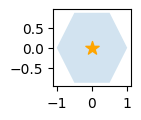

In [181]:
x,y = polygon.exterior.xy
plt.figure(figsize=(1,1))
plt.fill_between(x,y, alpha=0.2)
plt.scatter(cog.x, cog.y, c='orange', s=100, marker='*')
plt.show()

In [194]:
# Function to calculate stability index and whether COG is outside the support polygon
def calculate_stability(polygon, 
                        cog, 
                        test_leg_index, 
                        lifted_legs_index, 
                        visualize=False):
    # print('polygon: ', polygon)
    # Get the list of coordinates from the polygon's exterior
    lifted_leg = list(lifted_legs_index)
    lifted_leg.append(test_leg_index)
    coords = list(polygon.exterior.coords)

    # Remove the point at the specified index
    del coords[-1]
    for index in sorted(lifted_leg, reverse=True):
        del coords[index]
    
    if len(coords) == 2:
        for i in range(len(coords)):
            coords.insert(-1, coords[-1])
    elif len(coords) == 1:
        for i in range(3):
            coords.insert(-1, coords[-1])
    
    # Create a new polygon with the updated list of coordinates
    new_polygon = Polygon(coords)    
    # print('n_polygon: ', new_polygon)
    # new_cog = new_polygon.centroid
    # cog_point = Point(new_cog.x, new_cog.y)

    if visualize:
        plt.figure(figsize=(1,1))
        x,y = new_polygon.exterior.xy
        plotting.plot_polygon(new_polygon, alpha=0.2)
        plt.scatter(cog.x, cog.y, c='orange', s=100, marker='*')
        plt.xlim([-1.1, 1.1])
        plt.ylim([-1.1, 1.1])
        plt.show()

    # Calculate distance of COG to the nearest edge
    distance_to_edge = new_polygon.exterior.distance(cog)

    # Check if COG is outside the polygon
    is_outside = not new_polygon.contains(cog)

    # Return negative distance if COG is outside
    if is_outside:
        distance_to_edge = -distance_to_edge


    return distance_to_edge, is_outside

Lift Leg  1


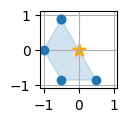

distance:  0.0
*** Stable ***

Lift Leg  2


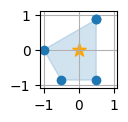

distance:  0.5
*** Stable ***

Lift Leg  3


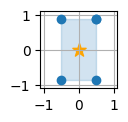

distance:  0.5
*** Stable ***

Lift Leg  4


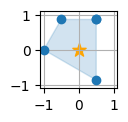

distance:  0.5
*** Stable ***

Lift Leg  5


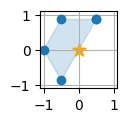

distance:  -0.0
___ Unstable ___



In [255]:
lifted_legs = {0}
for i in range(len(angles)):
    if i not in lifted_legs:
        print('Lift Leg ', i)
        stability_index, is_cog_outside = calculate_stability(polygon, cog, i, lifted_legs, visualize=True)
        print('distance: ', round(stability_index, 2))
        if is_cog_outside:
            print('___ Unstable ___')
        else:
            print('*** Stable ***')
        print()

In [ ]:
class GaitPlanner:
    def __init__(self, angles, leg_radius=1.0, max_legs_lifted=2, lifting_period=3):
        self.timesteps = 0
        self.gait_plan = []
        self.lifted_legs_timer = {} # Store lifted legs with their remaining time
        self.leg_stance_state = {}
        self.this_cycle_lifted = []
        self.leg_radius = leg_radius
        self.max_legs_lifted = max_legs_lifted
        self.lifting_period = lifting_period
        # timesteps = 0
        for i in range(len(angles)):
            self.lifted_legs_timer[i] = 0
            self.leg_stance_state[i] = True

    def calculate_support_polygon(self, angles, leg_radius=1):
        """
        Calculate the support polygon given leg angles and the COG of the polygon.
        Args:
            angles (list): Array of angles (0-360 degrees) for each leg.
            leg_radius (float): Distance of each leg's ground contact point from the center of the robot.

        Returns:
            polygon (Polygon): Support polygon formed by the leg ground contact points.
            cog (tuple): Center of gravity (centroid of the support polygon).
        """
        # Convert angles to Cartesian coordinates
        coords = [(leg_radius * np.cos(np.radians(angle)), 
                leg_radius * np.sin(np.radians(angle))) for angle in angles]
        polygon = Polygon(coords)
    
        # Calculate the centroid of the polygon
        cog = Point([0,0])  # Centroid of the polygon
        return polygon, cog

    # Function to calculate stability index and whether COG is outside the support polygon
    def calculate_stability(self,
                            polygon, 
                            cog, 
                            test_leg_index, 
                            lifted_legs_index, 
                            visualize=False):
        # print('polygon: ', polygon)
        # Get the list of coordinates from the polygon's exterior
        lifted_leg = list(lifted_legs_index)
        lifted_leg.append(test_leg_index)
        coords = list(polygon.exterior.coords)

        # Remove the point at the specified index
        del coords[-1]
        for index in sorted(lifted_leg, reverse=True):
            del coords[index]
        
        if len(coords) == 2:
            for i in range(len(coords)):
                coords.insert(-1, coords[-1])
        elif len(coords) == 1:
            for i in range(3):
                coords.insert(-1, coords[-1])
        
        # Create a new polygon with the updated list of coordinates
        new_polygon = Polygon(coords)    
        # print('n_polygon: ', new_polygon)
        # new_cog = new_polygon.centroid
        # cog_point = Point(new_cog.x, new_cog.y)

        if visualize:
            plt.figure(figsize=(1,1))
            x,y = new_polygon.exterior.xy
            plotting.plot_polygon(new_polygon, alpha=0.2)
            plt.scatter(cog.x, cog.y, c='orange', s=100, marker='*')
            plt.xlim([-1.1, 1.1])
            plt.ylim([-1.1, 1.1])
            plt.show()

        # Calculate distance of COG to the nearest edge
        distance_to_edge = new_polygon.exterior.distance(cog)

        # Check if COG is outside the polygon
        is_outside = not new_polygon.contains(cog)

        # Return negative distance if COG is outside
        if is_outside:
            distance_to_edge = -distance_to_edge


        return distance_to_edge, is_outside

    def gait_planner(self, angles, stability_threshold = 0):
        """
        Plan the gait for the hexapod robot.
        
        Args:
            angles (list): Array of angles of each leg (0-360 degrees).
            leg_radius (float): Distance of each leg's ground contact point from the robot center.
            max_legs_lifted (int): Maximum number of legs that can be lifted at the same time.
            max_timesteps (int): Maximum timesteps for the gait planner.
            lifting_period (int): The duration each leg stays lifted before returning to stance.
        
        Returns:
            gait_plan (list): Sequence of leg lifting actions.
            lifted_legs_timer (dict): Remaining lifted legs with their timers.
        """
        # print('leg_stance_state[i]')
        polygon, cog = self.calculate_support_polygon(angles)

        # Get the index of legs which are in stance phase
        # leg_stance_state[0] = False
        index_stance_leg = [key for key, value in self.leg_stance_state.items() if value]
        index_lifted_leg = [key for key, value in self.leg_stance_state.items() if not value]
        # print('index_stance_leg: ', index_stance_leg)
        # print('index_lifted_leg: ', index_lifted_leg)
        # print('this_cycle_lifted: ', self.this_cycle_lifted)
        
        # Update timers for lifted legs
        # print('lifted_legs_timer: ', self.lifted_legs_timer)
        for leg in list(self.lifted_legs_timer.keys()):
            self.lifted_legs_timer[leg] -= 1
            if self.lifted_legs_timer[leg] <= 0:
                # Leg has completed its lifting period, put it back to stance
                self.lifted_legs_timer[leg] = -1  # Mark it as ready for stance
                self.leg_stance_state[leg] = True
        
        # Stability prediction for each leg
        stability_scores = []
        for i in range(len(angles)):
            if i not in index_lifted_leg and i not in self.this_cycle_lifted:
                stability_index, is_cog_outside = self.calculate_stability(polygon, cog, i, index_lifted_leg, visualize=False)
                stability_scores.append((i, stability_index, is_cog_outside))
                # print('i: ', i)
                # print('stability_scores: ', stability_scores)
        
        # Sort stability scores in descending order (higher stability first)
        stability_scores.sort(reverse=True, key=lambda x: x[1])
        # print('stability_scores: ', stability_scores)

        # Check if the number of lifted legs is below the limit
        if len(index_lifted_leg) < self.max_legs_lifted:
            for leg_index, stability_index, is_cog_outside in stability_scores:
                if stability_index > stability_threshold:
                    self.lifted_legs_timer[leg_index] = self.lifting_period  # Start a timer for lifting this leg
                    self.leg_stance_state[leg_index] = False
                    self.this_cycle_lifted.append(leg_index)
                    if len(self.this_cycle_lifted) == len(angles):
                        self.this_cycle_lifted = []
                    break  # Only lift one leg at a time
        elif len(index_lifted_leg) == self.max_legs_lifted:
        # Wait for all legs to be lifted before proceeding
            print('Max leg lifting')
                        
        return self.leg_stance_state, index_lifted_leg

# Example usage
angles = [0, 60, 120, 180, 240, 300]  # Hexapod leg angles in degrees
max_timesteps = 20
gait_planner_hexa = GaitPlanner(angles)
for i in range(max_timesteps):
    print('timestep: ', i)
    gait_plan, lifted_legs = gait_planner_hexa.gait_planner(angles)
    print("Gait Plan (Timestep, Leg Lifting Order):", gait_plan)
    print("Remaining Lifted Legs (with timers):", lifted_legs)
    print()



timestep:  0
Gait Plan (Timestep, Leg Lifting Order): {0: False, 1: True, 2: True, 3: True, 4: True, 5: True}
Remaining Lifted Legs (with timers): []

timestep:  1
Gait Plan (Timestep, Leg Lifting Order): {0: False, 1: True, 2: True, 3: False, 4: True, 5: True}
Remaining Lifted Legs (with timers): [0]

timestep:  2
Max leg lifting
Gait Plan (Timestep, Leg Lifting Order): {0: False, 1: True, 2: True, 3: False, 4: True, 5: True}
Remaining Lifted Legs (with timers): [0, 3]

timestep:  3
Max leg lifting
Gait Plan (Timestep, Leg Lifting Order): {0: True, 1: True, 2: True, 3: False, 4: True, 5: True}
Remaining Lifted Legs (with timers): [0, 3]

timestep:  4
Gait Plan (Timestep, Leg Lifting Order): {0: True, 1: False, 2: True, 3: True, 4: True, 5: True}
Remaining Lifted Legs (with timers): [3]

timestep:  5
Gait Plan (Timestep, Leg Lifting Order): {0: True, 1: False, 2: True, 3: True, 4: False, 5: True}
Remaining Lifted Legs (with timers): [1]

timestep:  6
Max leg lifting
Gait Plan (Timestep

In [ ]:
leg_stance_state = {}
for i in range(6):
    leg_stance_state[i] = 0.5
    if leg_stance_state[i]:
        print(leg_stance_state[i])
    else:
        print('else: ', leg_stance_state[i])


else:  False
else:  False
else:  False
else:  False
else:  False
else:  False


# CPG neural Control

In [24]:
class CPG:
    """
    The CPG is based on SO2 CPG with MI modulation for diff frequency
    """
    def __init__(self, MI=0):
        # CPGs
        self.MI = MI
        self.w11, self.w22 = 1.4, 1.4
        self.w12 =  0.18 + MI
        self.w21 = -0.18 - MI
        self.o1 = 0.01
        self.o2 = 0.01
    
    def step(self):
        self.o1 = math.tanh(self.w11*self.o1 + self.w12*self.o2)
        self.o2 = math.tanh(self.w22*self.o2 + self.w21*self.o1)
        
    def get_CPG_output(self):
        return [self.o1, self.o2]
    
class MotorMapper:
    """
    A class responsible for mapping gait patterns to motor commands.
    Converts CPG outputs into joint position commands for each leg.
    """
    def __init__(self, num_legs, num_motors_per_leg):
        """
        Initializes the MotorMapper.

        Args:
            num_legs (int): Number of legs in the robot.
            num_motors_per_leg (int): Number of motors per leg.
        """
        self.num_legs = num_legs
        self.num_motors_per_leg = num_motors_per_leg
        self.weight_V_leg = [0] * num_motors_per_leg

    def set_weight_leg(self, weights = [0, 0, 0]):
        self.weight_V_leg = weights # 0, 1, 1

    def map_to_motors(self, cpg_outputs, gait_pattern):
        """
        Maps CPG outputs and gait pattern to motor joint positions.

        Args:
            cpg_outputs (np.array): Array of CPG outputs for each leg.
            gait_pattern (list): List specifying which leg to lift (1 for lift, 0 for grounded).

        Returns:
            dict: Dictionary with motor indices and corresponding joint positions.
        """
        motor_commands = [0] * self.num_legs * self.num_motors_per_leg
        for leg_id in range(self.num_legs):
            motor_index = leg_id * self.num_motors_per_leg
            # print(gait_pattern[leg_id])

            # If the gait pattern specifies lifting this leg, adjust the CPG output
            if gait_pattern[leg_id] == False:
                command = self.weight_V_leg  # Full amplitude for lifted leg
            else:
                command = [0, 0, 0]  # Set to zero (or adjust for grounded position)
            # print(command)

            # Store the command in the dictionary
            motor_commands[motor_index:motor_index+self.num_motors_per_leg] = command
        print(motor_commands)
        return motor_commands

# Example usage
angles = [0, 60, 120, 180, 240, 300]  # Hexapod leg angles in degrees
max_timesteps = 20
gait_planner_hexa = GaitPlanner(angles)
cpg = CPG()
motor_mapping = MotorMapper(6, 3)
motor_mapping.set_weight_leg([0, 0.1, 0.1])
for i in range(max_timesteps):
    print('timestep: ', i)
    gait_plan, lifted_legs = gait_planner_hexa.gait_planner(angles)
    print("Gait Plan (Timestep, Leg Lifting Order):", gait_plan)
    print("Remaining Lifted Legs (with timers):", lifted_legs)

    cpg.step()
    cpg_out = cpg.get_CPG_output()
    motor_commands = motor_mapping.map_to_motors(cpg_out, gait_plan)


    print()
        

timestep:  0
Gait Plan (Timestep, Leg Lifting Order): {0: False, 1: True, 2: True, 3: True, 4: True, 5: True}
Remaining Lifted Legs (with timers): []
[0, 0.1, 0.1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

timestep:  1
Gait Plan (Timestep, Leg Lifting Order): {0: False, 1: True, 2: True, 3: False, 4: True, 5: True}
Remaining Lifted Legs (with timers): [0]
[0, 0.1, 0.1, 0, 0, 0, 0, 0, 0, 0, 0.1, 0.1, 0, 0, 0, 0, 0, 0]

timestep:  2
Max leg lifting
Gait Plan (Timestep, Leg Lifting Order): {0: False, 1: True, 2: True, 3: False, 4: True, 5: True}
Remaining Lifted Legs (with timers): [0, 3]
[0, 0.1, 0.1, 0, 0, 0, 0, 0, 0, 0, 0.1, 0.1, 0, 0, 0, 0, 0, 0]

timestep:  3
Max leg lifting
Gait Plan (Timestep, Leg Lifting Order): {0: True, 1: True, 2: True, 3: False, 4: True, 5: True}
Remaining Lifted Legs (with timers): [0, 3]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.1, 0.1, 0, 0, 0, 0, 0, 0]

timestep:  4
Gait Plan (Timestep, Leg Lifting Order): {0: True, 1: False, 2: True, 3: True, 4: True, 5: True}

In [ ]:
neural_control = CPG

In [8]:
motor_commands = [] * 6 * 3
for leg_id in range(6):
    motor_index = leg_id * 3
    # If the gait pattern specifies lifting this leg, adjust the CPG output
    if [1,0,0,0,0,0][0] == 1:
        command = [0,1,1]  # Full amplitude for lifted leg
    else:
        command = 0.0  # Set to zero (or adjust for grounded position)

    # Store the command in the dictionary
    motor_commands[motor_index:motor_index+3] = command


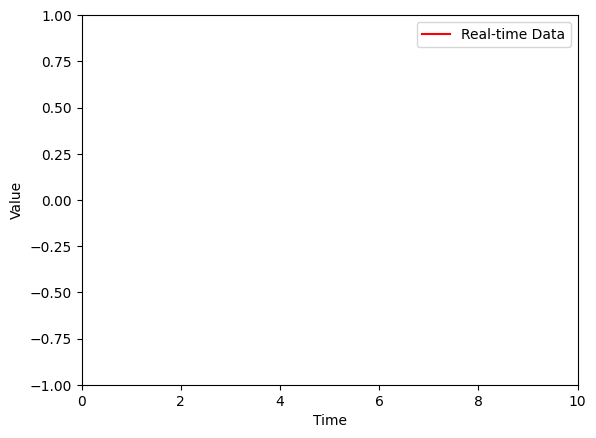

In [4]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.animation import FuncAnimation
import time

# Create a figure and an axis
fig, ax = plt.subplots()

# Initialize the data
xdata, ydata = [], []
line, = ax.plot([], [], 'r-', label="Real-time Data")
ax.set_xlim(0, 10)  # Set the x-axis range
ax.set_ylim(-1, 1)  # Set the y-axis range
ax.set_xlabel('Time')
ax.set_ylabel('Value')
ax.legend()

# Initialize function to set up the plot
def init():
    line.set_data([], [])
    return line,

# Update function that will be called at each frame
def update(frame):
    # Example: simulate some time series data (sin wave here)
    current_time = time.time()  # You could replace this with actual timestamp data
    xdata.append(current_time)
    ydata.append(np.sin(current_time))  # Use actual data here

    # Update plot
    ax.set_xlim(current_time - 10, current_time)  # Shift the window to the latest 10 seconds of data
    line.set_data(xdata, ydata)
    return line,

# Create the animation
ani = FuncAnimation(fig, update, frames=np.arange(0, 100), init_func=init, blit=True, interval=1000)

# Show the plot
plt.show()